In [ ]:
%load_ext autoreload
%autoreload 2

# append parent directory to path (../notebooks -> ..) this cell should be run once.
import os
import sys
# otherwise it goes one more level up
sys.path.append(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

import accelerate
import lovely_tensors as lt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import yaml
from diffusers.optimization import get_scheduler
from omegaconf import OmegaConf
from tqdm.auto import tqdm

from ldns.data.latent_attractor import get_attractor_dataloaders
from ldns.networks import AutoEncoder, CountWrapper
from ldns.utils.plotting_utils import *
from ldns.networks import Denoiser
from diffusers.training_utils import EMAModel
from diffusers.schedulers import DDPMScheduler

lt.monkey_patch()
matplotlib.rc_file('matplotlibrc') # mackelab plotting style



In [2]:

cfg_ae = OmegaConf.load("conf/autoencoder-Lorenz_z=8.yaml") # cfg that was saved while training the autoencoder


cfg_yaml = """
denoiser_model:
  C_in: 8 
  C: 64
  num_blocks: 4 
  bidirectional: True
  num_train_timesteps: 1000 # DDPM denoising steps
training:
  lr: 0.001
  num_epochs: 1000
  num_warmup_epochs: 50
  batch_size: 512
  random_seed: 42
  precision: "no"
exp_name: diffusion_Lorenz
"""

cfg = OmegaConf.create(yaml.safe_load(cfg_yaml))
cfg.dataset = cfg_ae.dataset


In [3]:
# save the cfg
with open(f"conf/{cfg.exp_name}.yaml", "w") as f:
    f.write(OmegaConf.to_yaml(cfg))


In [ ]:
# create the autoencoder model and load checkpoint
    
ae_model = AutoEncoder(
    C_in=cfg_ae.model.C_in,
    C=cfg_ae.model.C,
    C_latent=cfg_ae.model.C_latent,
    L=cfg_ae.dataset.signal_length,
    num_blocks=cfg_ae.model.num_blocks,
    num_blocks_decoder=cfg_ae.model.num_blocks_decoder,
    num_lin_per_mlp=cfg_ae.model.get("num_lin_per_mlp", 2),  # default 2
)

ae_model = CountWrapper(ae_model)

ae_model.load_state_dict(torch.load(f"exp/{cfg_ae.exp_name}/model.pt", map_location="cpu"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ae_model = ae_model.to(device)

train_dataloader, val_dataloader, test_dataloader = get_attractor_dataloaders(
    system_name=cfg_ae.dataset.system_name,
    n_neurons=cfg_ae.model.C_in,
    sequence_length=cfg_ae.dataset.signal_length,
    n_ic=cfg_ae.dataset.n_ic,
    mean_spike_count=cfg_ae.dataset.mean_rate * cfg.dataset.signal_length,
    train_frac=cfg_ae.dataset.split_frac_train,
    valid_frac=cfg_ae.dataset.split_frac_val, # test is 1 - train - valid
    random_seed=cfg_ae.training.random_seed, # reproducibility
    batch_size=cfg_ae.training.batch_size,
    softplus_beta=cfg_ae.dataset.get("softplus_beta", 2.0),
)


In [7]:
# setup the accelerator to load the autoencoder model onto the gpu

# check if signal length is power of 2
if cfg.dataset.signal_length & (cfg.dataset.signal_length - 1) != 0:
    cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x


accelerator = accelerate.Accelerator(
    mixed_precision=cfg.training.precision,
    log_with="wandb",
)

# prepare the ae model and dataset
(
    ae_model,
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    ae_model,
    train_dataloader,
    val_dataloader,
    test_dataloader,
)

In [ ]:
# set up the latent dataset here
from ldns.data.latent_attractor import LatentDataset

# create the latent dataset
latent_dataset_train = LatentDataset(train_dataloader, ae_model)
latent_dataset_val = LatentDataset(
    val_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means, # reuse mean from train data
    latent_stds=latent_dataset_train.latent_stds, # reuse std from train data
)
latent_dataset_test = LatentDataset(
    test_dataloader,
    ae_model,
    latent_means=latent_dataset_train.latent_means, # reuse mean from train data
    latent_stds=latent_dataset_train.latent_stds, # reuse std from train_data
)

latent dataset tensor[3500, 8, 256] n=7168000 (27Mb) x∈[-5.000, 5.000] μ=-0.001 σ=0.983
latent dataset means tensor[1, 8, 1] x∈[-0.451, 0.444] μ=-0.079 σ=0.264 [[[0.045], [0.444], [-0.059], [-0.284], [-0.030], [-0.451], [-0.093], [-0.200]]]
latent dataset stds tensor[1, 8, 1] x∈[0.154, 0.745] μ=0.465 σ=0.226 [[[0.154], [0.654], [0.218], [0.745], [0.239], [0.551], [0.584], [0.577]]]


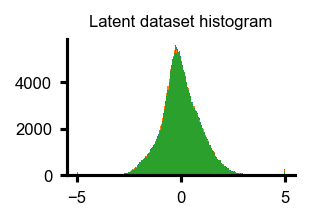

In [9]:
# sanity check, visualize if values are roughly in same range

print("latent dataset", latent_dataset_train.latents)
print("latent dataset means", latent_dataset_train.latent_means)
print("latent dataset stds", latent_dataset_train.latent_stds)
plt.figure(figsize=cm2inch(5, 3))
hist = plt.hist(latent_dataset_train.latents[:100].flatten(), bins=200)
hist = plt.hist(latent_dataset_val.latents[:100].flatten(), bins=200)
hist = plt.hist(latent_dataset_test.latents[:100].flatten(), bins=200)

plt.title("Latent dataset histogram")
plt.show()

In [12]:
# make the denoiser model and scheduler, load the model to the device

denoiser = Denoiser(
    C_in=cfg.denoiser_model.C_in,
    C=cfg.denoiser_model.C,
    L=cfg.dataset.signal_length,
    num_blocks=cfg.denoiser_model.num_blocks,
    bidirectional=cfg.denoiser_model.get("bidirectional", True),
)

scheduler = DDPMScheduler(
    num_train_timesteps=cfg.denoiser_model.num_train_timesteps,
    clip_sample=False,
    beta_schedule="linear", # doesnt support cosine noise schedule for now
)

optimizer = torch.optim.AdamW(
    denoiser.parameters(), lr=cfg.training.lr
)  # default wd=0.01 for now

train_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_train,
    batch_size=cfg.training.batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_val,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

test_latent_dataloader = torch.utils.data.DataLoader(
    latent_dataset_test,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

num_batches = len(train_latent_dataloader)
lr_scheduler = get_scheduler(
    name="cosine", # cosine decay with linear warmup
    optimizer=optimizer,
    num_warmup_steps=num_batches * cfg.training.num_warmup_epochs,  # warmup for 10% of epochs
    num_training_steps=num_batches * cfg.training.num_epochs * 1.3,  # total number of steps
)

# check if signal length is power of 2
if cfg.dataset.signal_length & (cfg.dataset.signal_length - 1) != 0:
    cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x

# prepare the denoiser model and dataset
(
    denoiser,
    train_latent_dataloader,
    val_latent_dataloader,
    test_latent_dataloader,
    lr_scheduler,
) = accelerator.prepare(
    denoiser,
    train_latent_dataloader,
    val_latent_dataloader,
    test_latent_dataloader,
    lr_scheduler,
)

ema_model = EMAModel(denoiser) # exponential moving average, makes diffusion model better during inference

In [14]:
# sampling function for diffusion model

def sample(
    ema_denoiser,
    scheduler,
    cfg,
    batch_size=1,
    generator=None,
    device="cuda",
    signal_length=None
):  
    """Sample from the denoiser model.
    Args:
        ema_denoiser: EMA model to sample from
        scheduler: scheduler to use for sampling
        cfg: config
        batch_size: batch size
        generator: generator to use for sampling
        device: device to use for sampling
        signal_length: signal length to use for sampling
    
    Returns:
        z_t: sampled latents
    """
    if signal_length is None:
        signal_length = cfg.dataset.signal_length
    z_t = torch.randn(
        (batch_size, cfg.denoiser_model.C_in, signal_length)
    ).to(device)
    ema_denoiser_avg = ema_denoiser.averaged_model
    ema_denoiser_avg.eval()

    scheduler.set_timesteps(cfg.denoiser_model.num_train_timesteps)

    for t in tqdm(scheduler.timesteps, desc="Sampling DDPM"):
        with torch.no_grad():
            model_output = ema_denoiser_avg(
                z_t, torch.tensor([t] * batch_size).to(device).long()
            )
        z_t = scheduler.step(
            model_output, t, z_t, generator=generator, return_dict=False
        )[0]

    return z_t


# train the diffusion model

epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

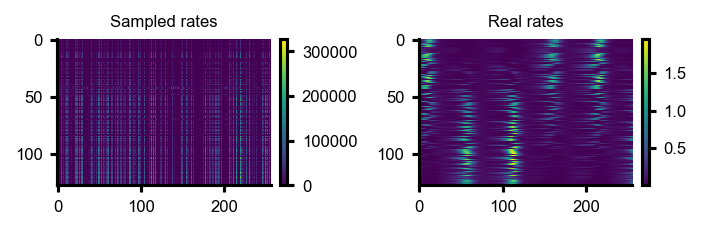

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

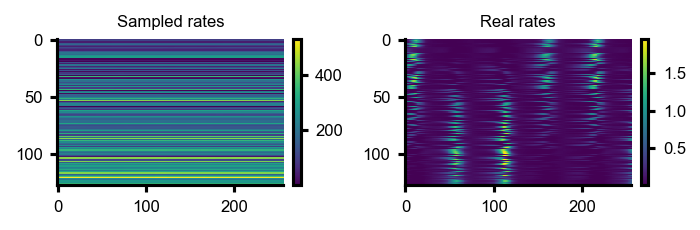

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

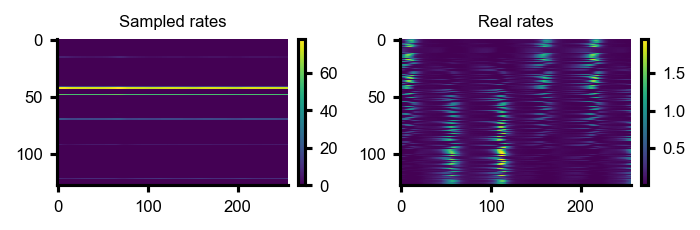

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

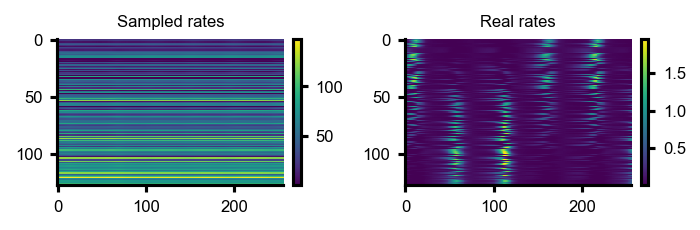

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

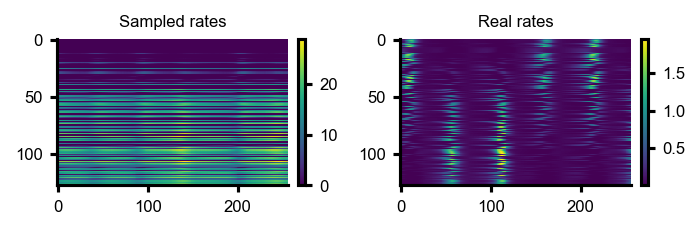

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

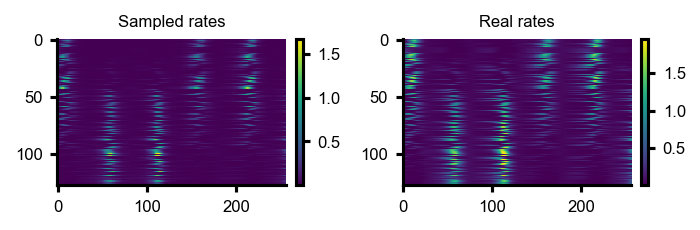

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

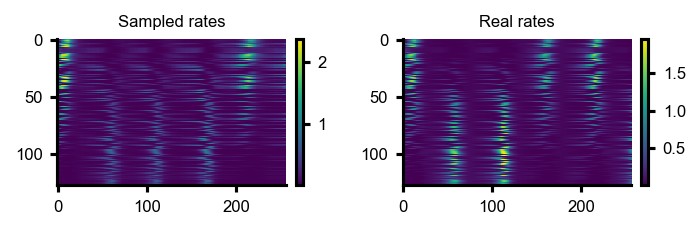

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

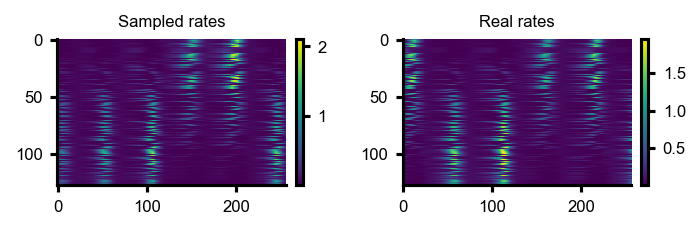

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

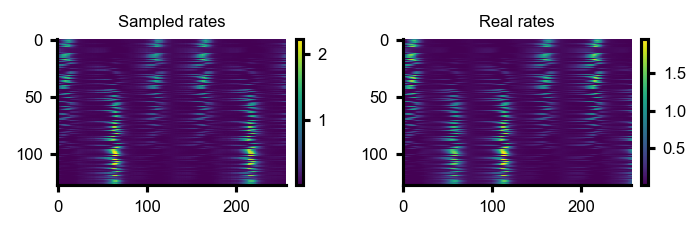

Sampling DDPM:   0%|          | 0/1000 [00:00<?, ?it/s]

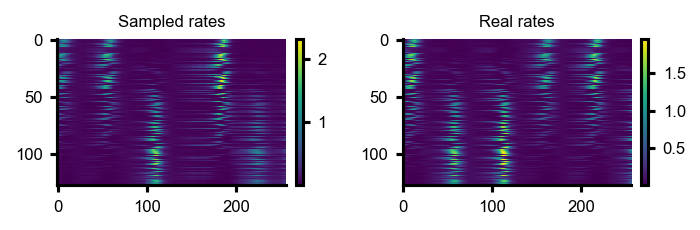

In [15]:
# sampled rates will be very high and erratic at the beginning of the training,
# but will settle down to the true range by the end
# this is expected behavior

pbar = tqdm(range(cfg.training.num_epochs), desc="epochs")
for epoch in pbar:
    for i, batch in enumerate(train_latent_dataloader):

        optimizer.zero_grad()

        z = batch
        t = torch.randint(
            0, cfg.denoiser_model.num_train_timesteps, (z.shape[0],), device="cpu"
        ).long()
        # print(z.shape, t.shape)
        noise = torch.randn_like(z)
        noisy_z = scheduler.add_noise(z, noise, t)
        noise_pred = denoiser(noisy_z, t)

        loss = torch.nn.functional.mse_loss(noise, noise_pred)
        accelerator.backward(loss)
        accelerator.clip_grad_norm_(denoiser.parameters(), 1.0)

        optimizer.step()
        lr_scheduler.step()

        if i % 10 == 0:
            pbar.set_postfix({"loss": loss.item(), "lr": lr_scheduler.get_last_lr()[0]})

        ema_model.step(denoiser)

    if (epoch) % 100 == 0: # plot samples

        sampled_latents = sample(
            ema_denoiser=ema_model, scheduler=scheduler, cfg=cfg, batch_size=2, device="cuda"
        )
        sampled_latents = sampled_latents * latent_dataset_train.latent_stds.to(
            sampled_latents.device
        ) + latent_dataset_train.latent_means.to(sampled_latents.device)
        with torch.no_grad():
            sampled_rates = ae_model.decode(sampled_latents).cpu()

        fig, ax = plt.subplots(1, 2, figsize=cm2inch(12,4))
        im = ax[0].imshow(sampled_rates[0], aspect='auto')
        ax[0].set_title("Sampled rates")
        fig.colorbar(im, ax=ax[0], orientation='vertical', fraction=0.046, pad=0.04)

        im = ax[1].imshow(train_dataloader.dataset.dataset[0]["rates"], aspect='auto')
        ax[1].set_title("Real rates")
        fig.colorbar(im, ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)
        fig.tight_layout()
        plt.show()

pbar.close()

In [ ]:
# save the model
os.makedirs('exp/'+cfg.exp_name, exist_ok=True)
torch.save(accelerator.unwrap_model(ema_model.averaged_model).state_dict(), f"exp/{cfg.exp_name}/model.pt") # end of training


To evaluate the diffusion model, head to `notebooks/plotting_diffusion_Lorenz.ipynb`
